<a href="https://colab.research.google.com/github/lblogan14/bayes_methods_for_hackers/blob/main/ch4_greatest_theorem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 4. The Greatest Theorem Never Told

##The Law of Large Numbers
Let $Z_i$ be $N$ independent samples from some probability distribution. According to the Law of Large Numbers, so long as the expected value $E[Z]$ is not infinity, the following holds:
$$\frac{1}{N}\sum^N_{i=1}Z_i\rightarrow E[Z],\quad N\rightarrow\infty$$

The following plot shows the Law of Large Numbers in action for three different sequences of Poisson random variables.

Sampling `sample_size=100000` Poisson random variables with parameter $\lambda=4.5$, then calculating the average for the first $n$ samples, for `n=1` to `sample_size`.

In [1]:
!pip install pymc

     |████████████████████████████████| 389kB 2.8MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp36-cp36m-linux_x86_64.whl size=1275935 sha256=8739c018ad4232463a2b58038704bf7f1dbb20e00aeab13a4531c8fec356b3ef
  Stored in directory: /root/.cache/pip/wheels/0b/a8/e7/8f3ba91a39294d538a92db052fd1fcba1fca74a58c8b022026
Successfully built pymc


In [2]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

import pymc as pm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
sample_size = 100000
expected_value = lambda_ = 4.5
poi = pm.rpoisson
N_samples = range(1, sample_size, 100)

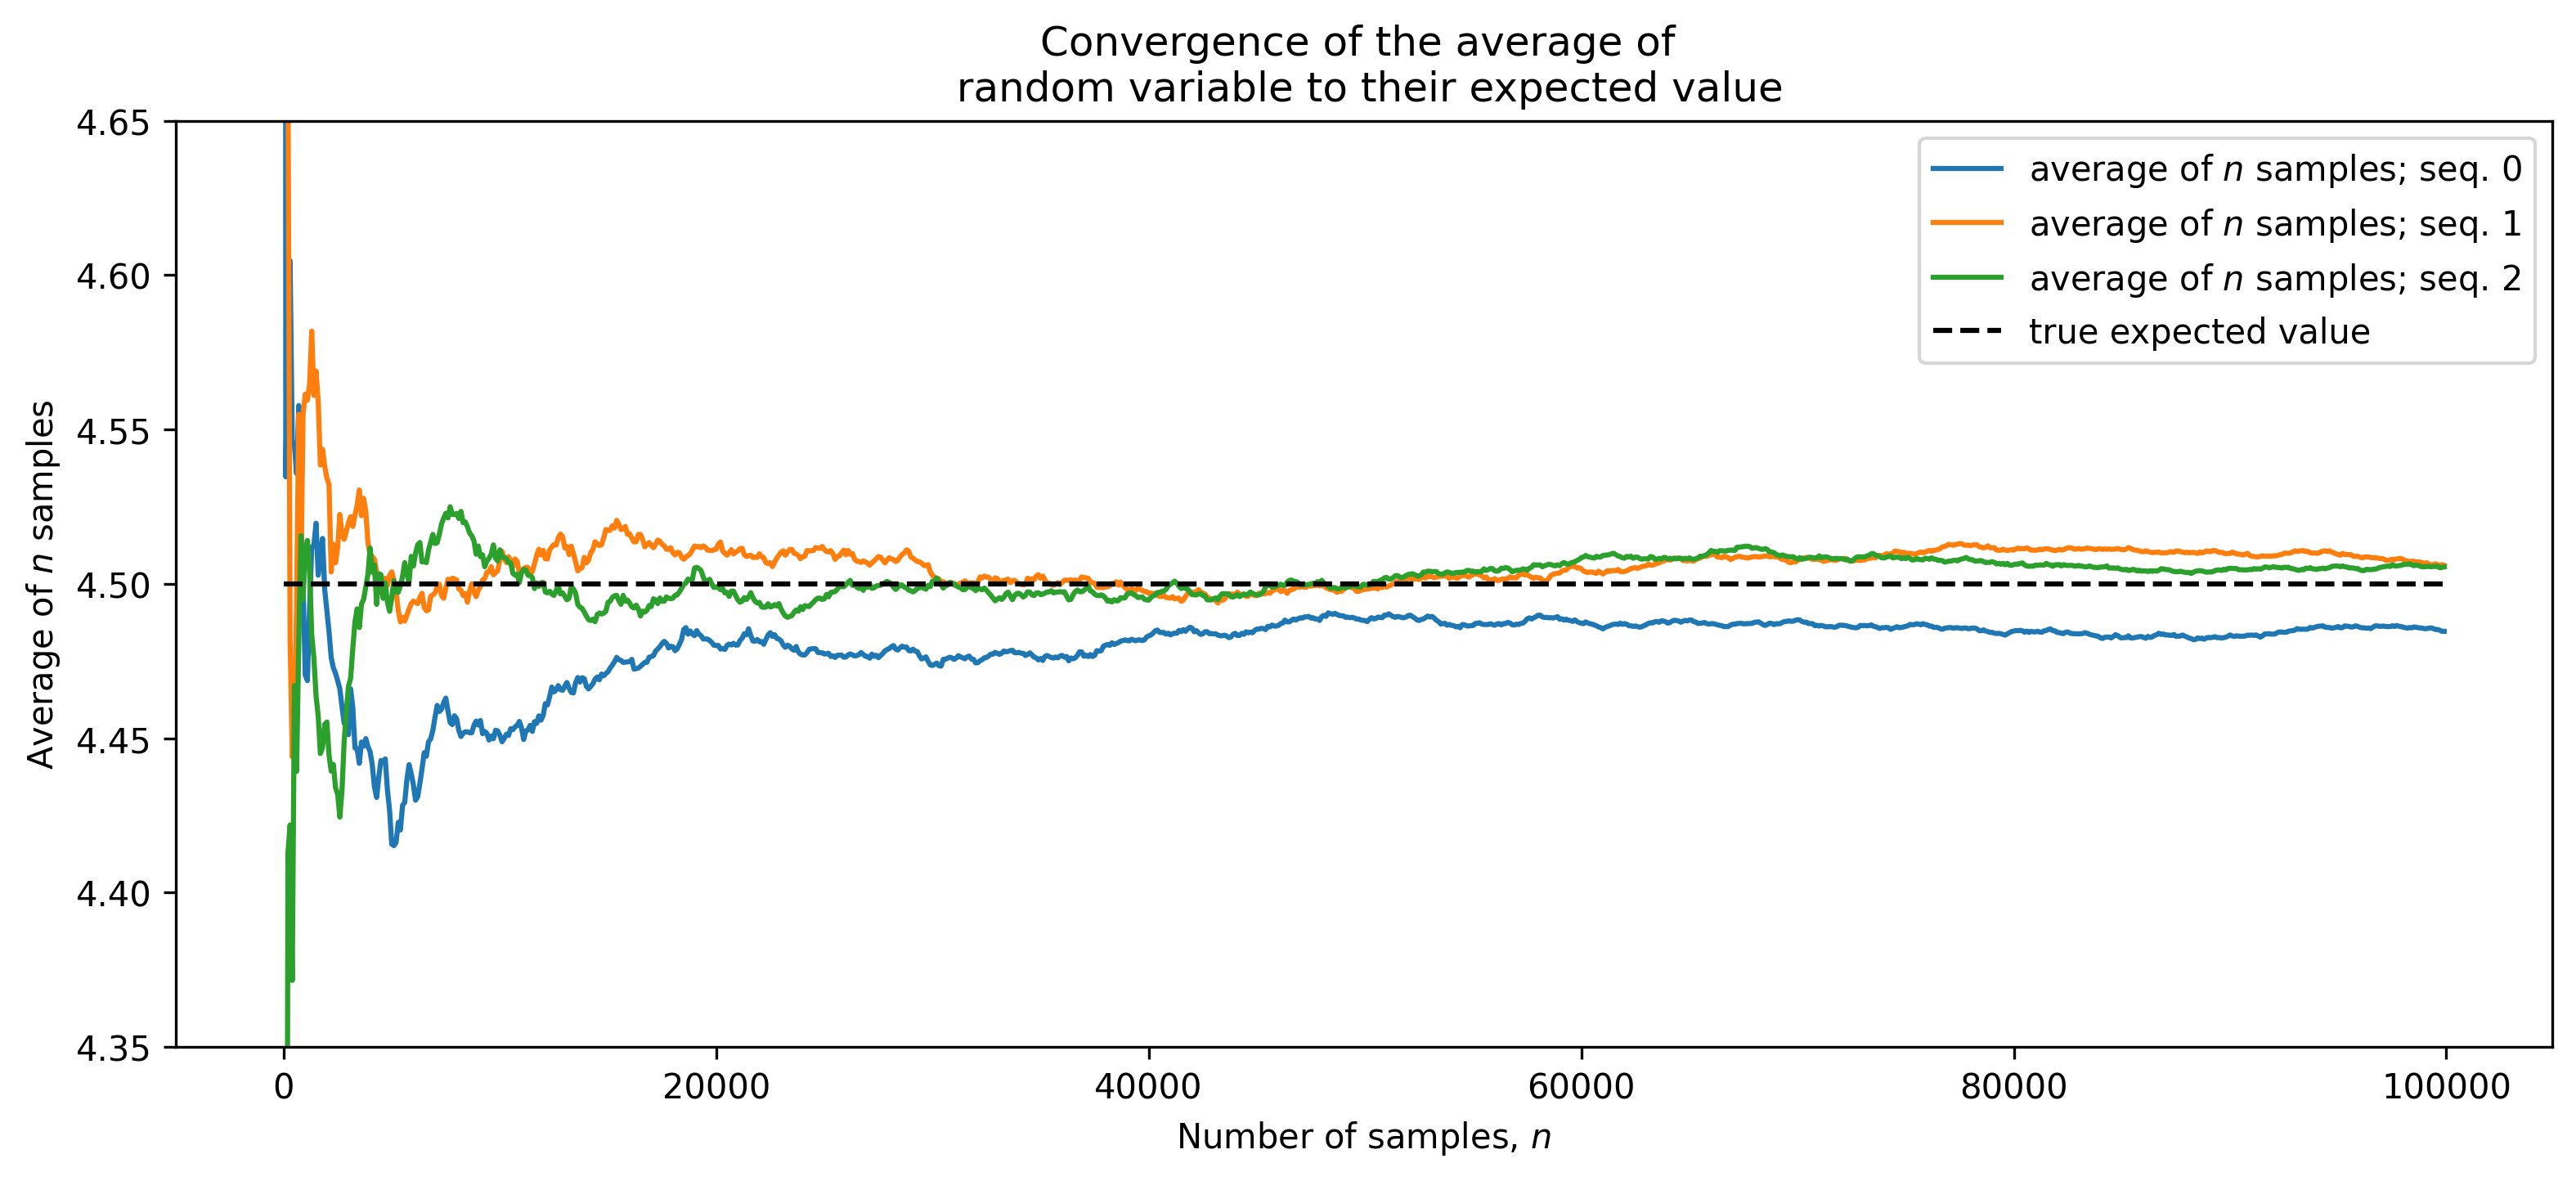

In [5]:
figsize(12.5, 5)
for k in range(3):
    samples = poi(lambda_, size=sample_size)
    partial_average = [samples[:i].mean() for i in N_samples]
    plt.plot(N_samples, partial_average, lw=1.5,
             label='average of $n$ samples; seq. {}'.format(k))
plt.plot(N_samples, expected_value*np.ones_like(partial_average), ls='--',
         label='true expected value', c='k')
plt.ylim(4.35, 4.65)
plt.title('Convergence of the average of \n random variable to their expected value')
plt.ylabel('Average of $n$ samples')
plt.xlabel('Number of samples, $n$')
plt.legend();

When the sample size is small, there is greater variation in the average (compare how jagged and jumpy the average is initially to when smooths out).

For a specific $n$, compute how far away from the true expected value on average based on thousands of trials:
$$D(n)=\sqrt{E\left[\left(\frac{1}{n}\sum^n_{i=1}Z_i-\lambda\right)^2\right]}$$
This is a distance away from the true value for some $n$. Instead of averaging $Z_i$, we can calculate the following multiple times and average them:
$$Y_{n,k}=\left(\frac{1}{n}\sum^n_{i=1}Z_i-\lambda\right)^2$$
By computing $Y_{n,k}$ many times, each time with new $Z_i$'s, and averaging them:
$$\frac{1}{N}\sum^N_{k=1}Y_{n,k}\rightarrow E[Y_n]=E\left[\left(\frac{1}{n}\sum^n_{i=1}Z_i-\lambda\right)^2\right]$$
Then,
$$\sqrt{\frac{1}{N}\sum^N_{k=1}Y_{n,k}}\approx D(n)$$

In [6]:
figsize(12.5, 4)
N_Y = 250 # Use this many to approximate D(N).
# Use this many samples in the approximation to the variance
N_array = np.arange(1000, 50000, 2500)
D_N_results = np.zeros(len(N_array))

lambda_ = 4.5
expected_value = lambda_ # for X ~ Poi(lambda), E[X]=lambda

def D_N(n):
    '''
    This function approximates D_n, the average variance of using n samples
    '''
    Z = poi(lambda_, size=(n, N_Y))
    average_Z = Z.mean(axis=0)
    return np.sqrt(((average_Z - expected_value)**2).mean())

for i,n in enumerate(N_array):
    D_N_results[i] = D_N(n)

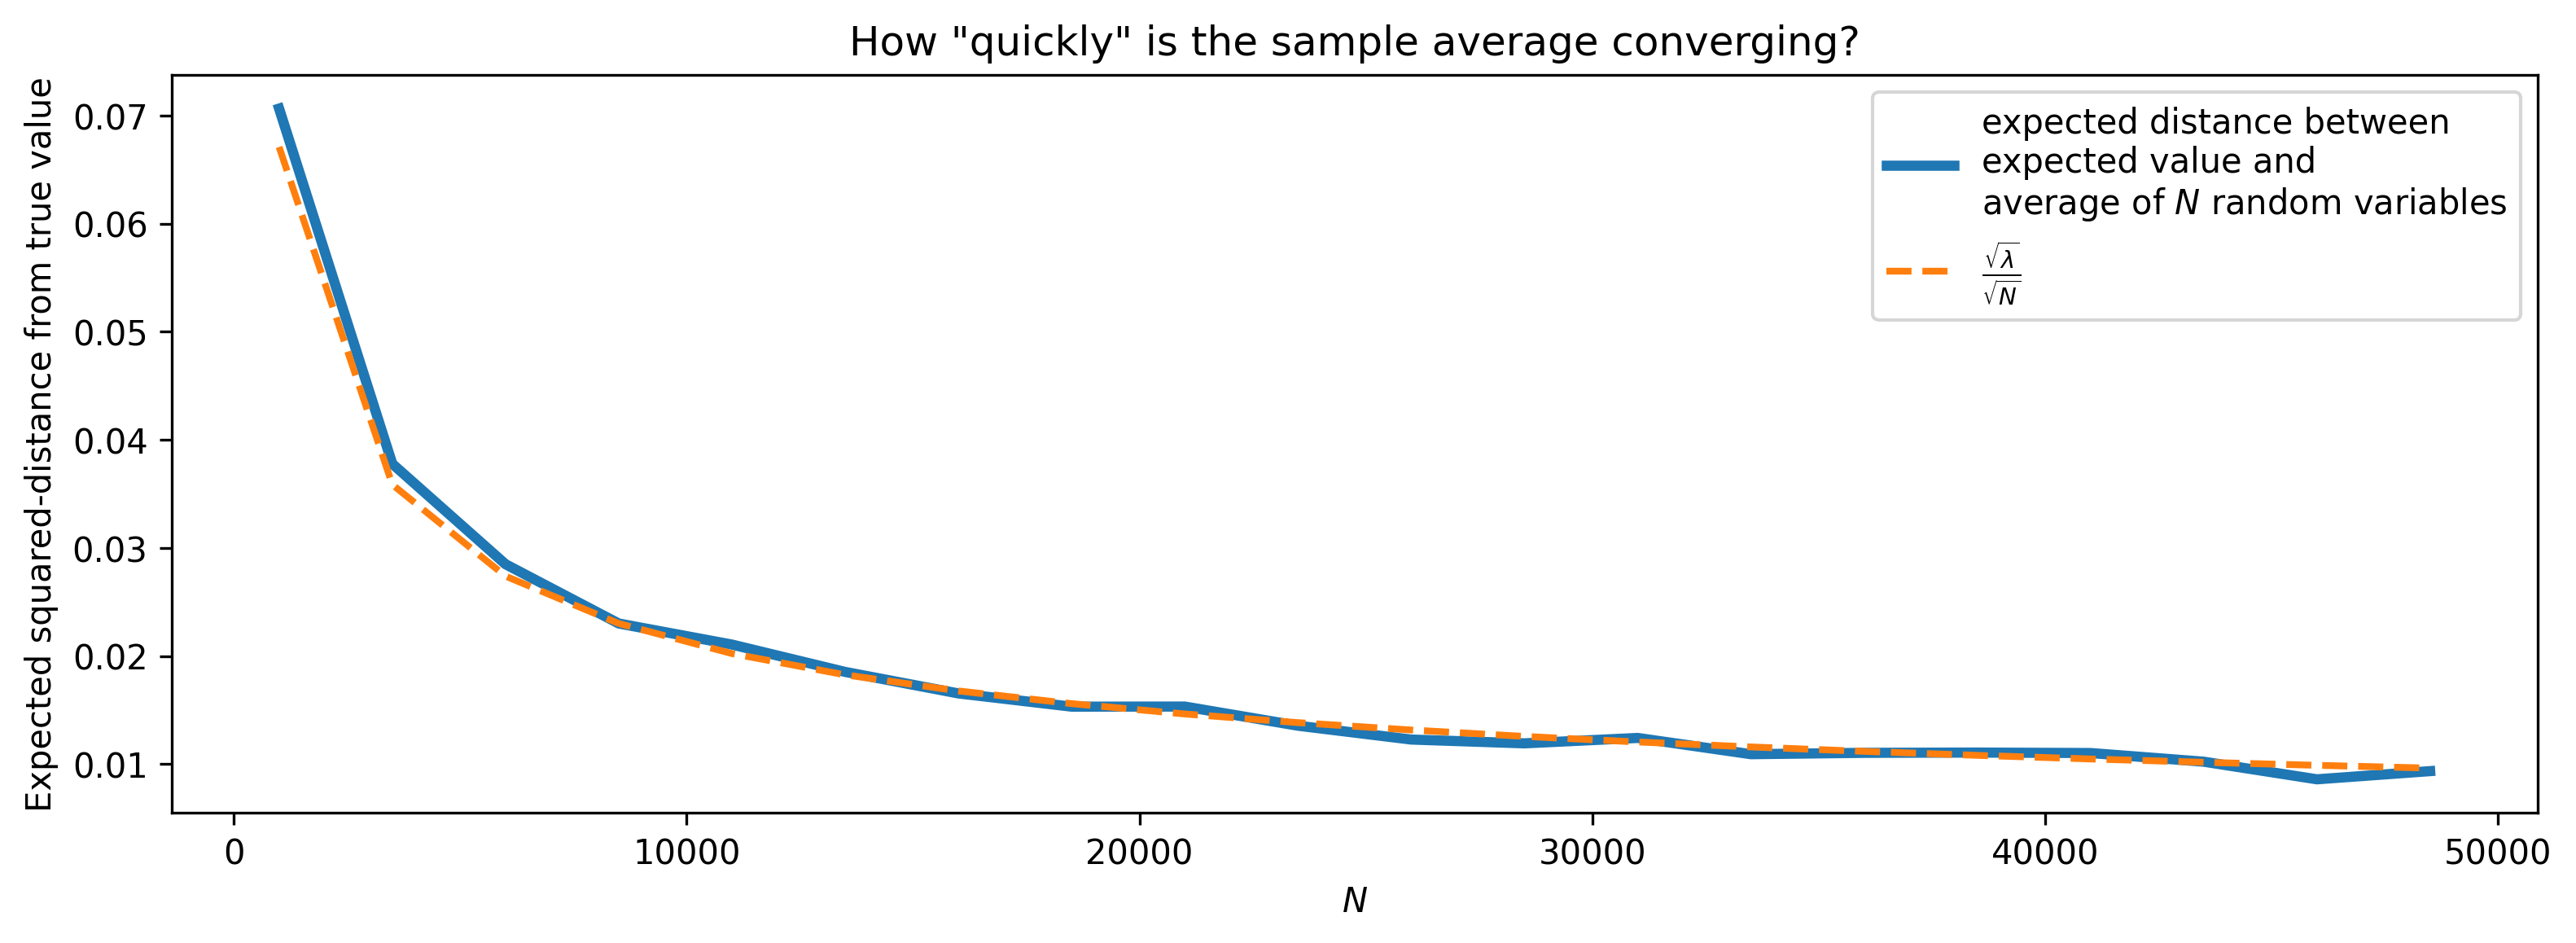

In [7]:
plt.xlabel('$N$')
plt.ylabel('Expected squared-distance from true value')
plt.plot(N_array, D_N_results, lw=3,
         label='expected distance between\nexpected value and \naverage of $N$ random variables')
plt.plot(N_array, np.sqrt(expected_value)/np.sqrt(N_array), lw=2, ls='--',
         label=r'$\frac{\sqrt{\lambda}}{\sqrt{N}}$')
plt.legend()
plt.title('How "quickly" is the sample average converging?');

In most cases, given a sequence of random variables distributed like $Z$, the rate of converge to $E[Z]$ of the Law of Large Numbers is
$$\frac{\sqrt{Var(Z)}}{\sqrt{N}}$$

The variance can be estimated by
$$\frac{1}{N}\sum^N_{i=1}(Z_i-\mu)^2\rightarrow E[(Z-\mu)^2]=Var(Z)$$



Define an *indicator function*:
$$F_A(x)=\begin{cases}
1 & x\in A\\
0 & else
\end{cases}$$
By the Law of Large Numbers, if there are many samples $X_i$, the probability of an event $A$, denoted $P(A)$, can be estimated by
$$\frac{1}{N}\sum^N_{i=1}F_A(X_i)\rightarrow E[F_A(X)]=P(A)$$

##The Disorder of Small Numbers

###Example: Aggregated Geographic Data
5000 counties in the toy dataset. Population numbers in each state are uniformly distributed between 100 and 1500. Each individual has the same height distribution:
$$\text{height}\sim Normal(150,15)$$

In [8]:
std_height = 15
mean_height = 150
n_counties = 5000
pop_generator = pm.rdiscrete_uniform
norm = pm.rnormal

# generate some artificial population numbers
population = pop_generator(100, 1500, size=n_counties)

average_across_county = np.zeros(n_counties)
for i in range(n_counties):
    # generate some individuals and take the mean
    average_across_county[i] = norm(mean_height, 1./std_height**2,
                                    size=population[i]).mean()

# locate the counties with the apparently most extreme average heights
i_min = np.argmin(average_across_county)
i_max = np.argmax(average_across_county)

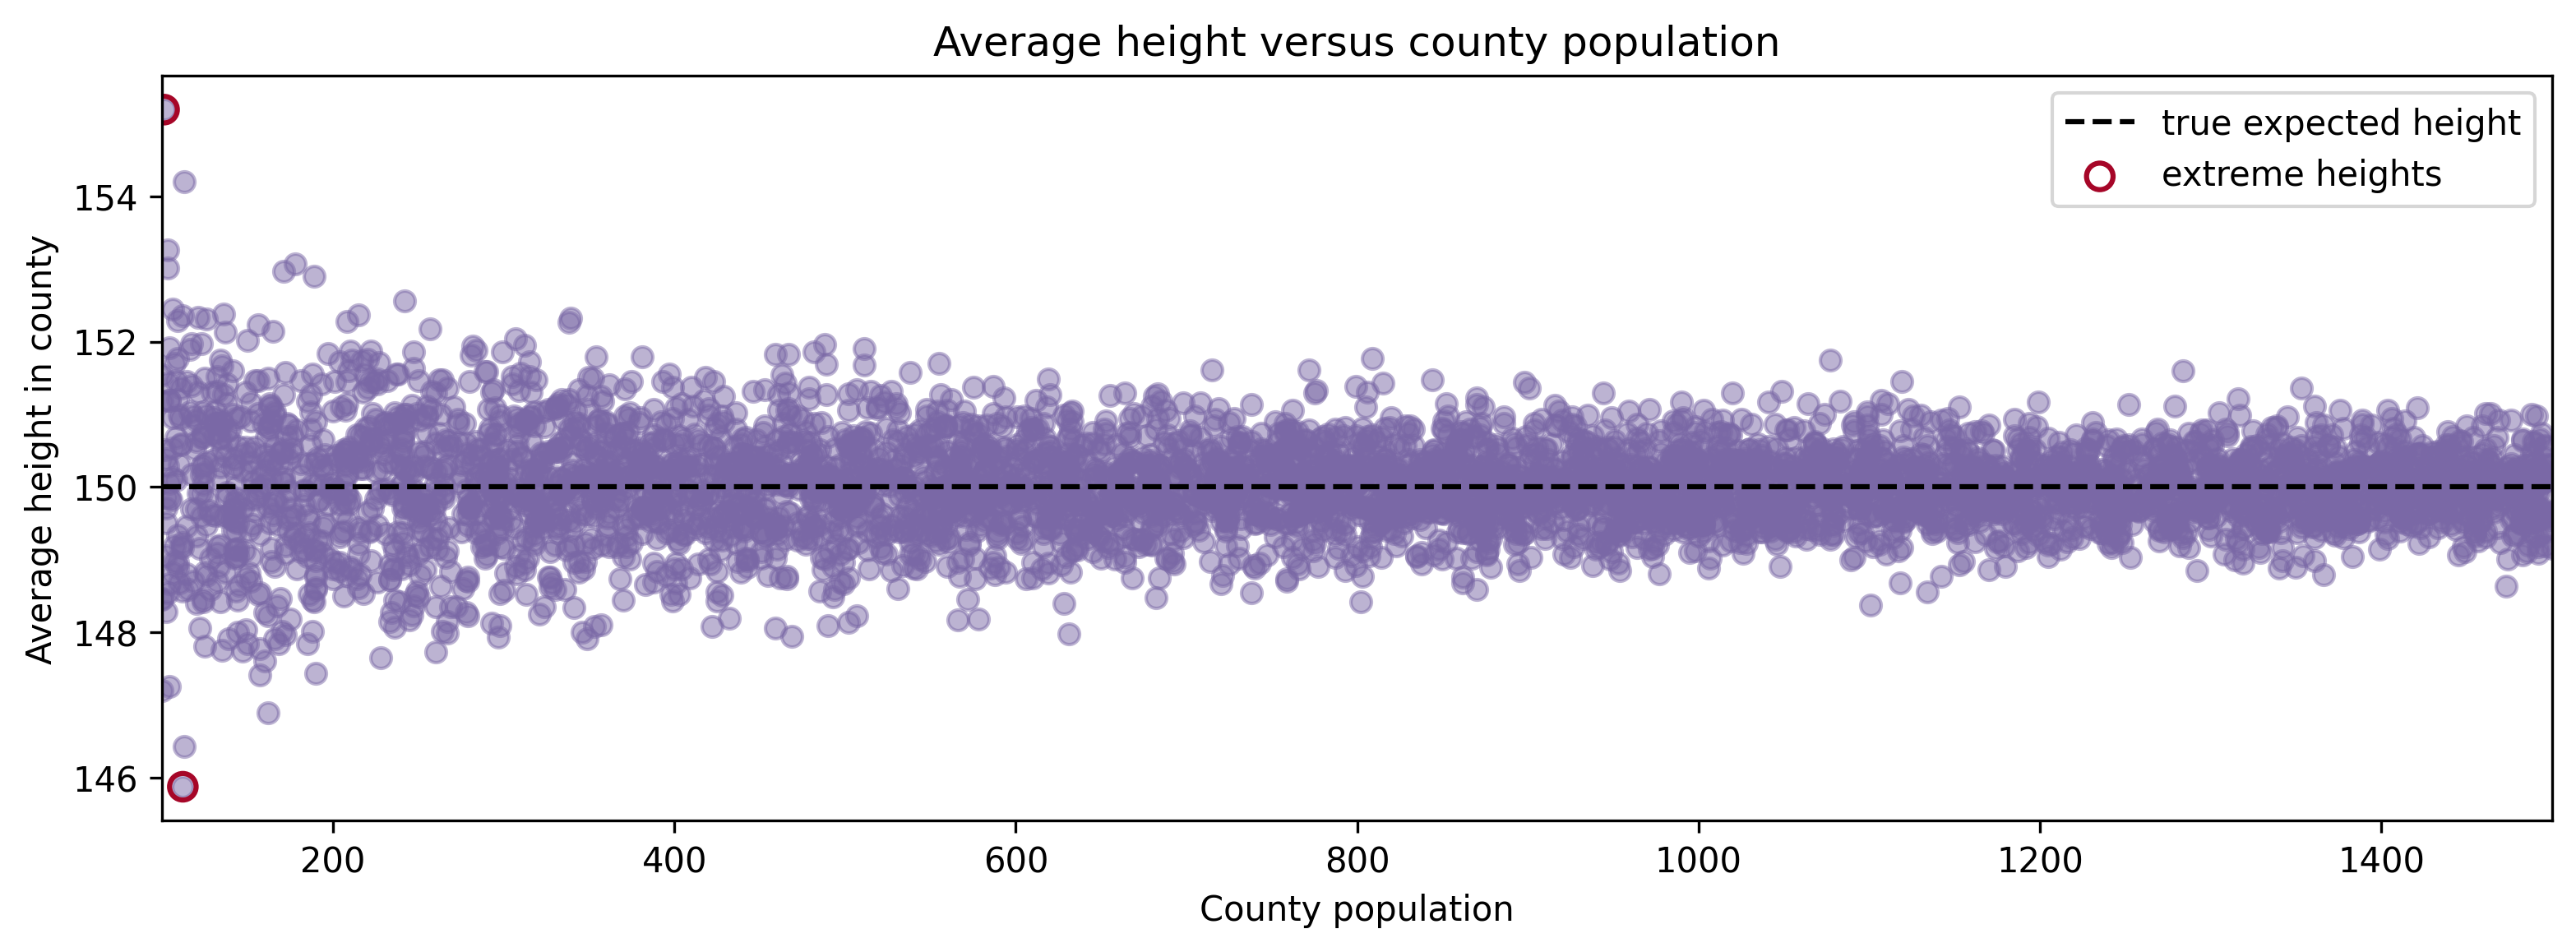

In [9]:
figsize(12.5, 4)
plt.scatter(population, average_across_county, alpha=0.5, c='#7A68A6')
plt.scatter([population[i_min], population[i_max]],
            [average_across_county[i_min], average_across_county[i_max]],
            s=60, marker='o', facecolors='none',
            edgecolors='#A60628', linewidths=1.5,
            label='extreme heights')

plt.xlim(100, 1500)
plt.title('Average height versus county population')
plt.xlabel('County population')
plt.ylabel('Average height in county')
plt.plot([100,1500], [150,150], color='k', label='true expected height', ls='--')
plt.legend(scatterpoints=1);

In [10]:
print('Population sizes of 10 "shortest" counties: ')
print(population[np.argsort(average_across_county)[:10]])
print()
print('Population sizes of 10 "tallest" counties: ')
print(population[np.argsort(-average_across_county)[:10]])

Population sizes of 10 "shortest" counties: 
[112 113 162 100 104 157 190 160 228 260]

Population sizes of 10 "tallest" counties: 
[101 113 103 178 103 171 189 242 106 136]
